# Querying news articles via Stardog

News articles ingested in the notebook, Demo_Article_Ingest, with execution/visualization of these in the cells below.


In [1]:
from dataclasses import dataclass
from dotenv import load_dotenv
import os
import pandas as pd
import panel as pn
import requests
import stardog

load_dotenv()  # take environment variables from .env

pn.extension('tabulator')

sd_dna = 'dna'
sd_conn_details = {'endpoint': os.environ.get('STARDOG_ENDPOINT'),
                   'username': os.getenv('STARDOG_USER'),
                   'password': os.environ.get('STARDOG_PASSWORD')}
dna = 'urn:ontoinsights:dna'

conn = stardog.Connection(sd_dna, **sd_conn_details)

In [2]:
article_collection = ['fl_abortion', 'landslide', 'trump_trial']

sources = ['Al Jazeera', 'Breitbart', 'CNN', 'Fox News', 'Huffington Post',
           'New York Times', 'Wall Street Journal', 'Washington Times' ]  

In [3]:
# Queries

# Article length (number of sentences)
length_query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select * where { ' \
    '    graph ?defGraph { ?narrative a :Narrative ; :source ?source ; :number_sentences ?numbSents} ' \
    '} ORDER BY DESC(?numbSents)'

# Person or org mentions
names_query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select ?agent (COUNT(?sent) as ?cnt) where { ' \
    '    ?type rdfs:subClassOf* ?baseType ' \
    '    {graph ?defGraph {?agent a ?type . FILTER NOT EXISTS{?agent a :GeopoliticalEntity}}} ' \
    '    {graph ?narrGraph {?sent a :Sentence ; :mentions ?agent}} ' \
    '} GROUP BY ?agent'

# Sentiment
sentiment_query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select ?sentiment (COUNT(?sent) as ?cnt) where { ' \
    '    graph ?narrGraph {?sent a :Sentence ; :sentiment ?sentiment} ' \
    '} GROUP BY ?sentiment'

# Average grade level
grade_query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select (COUNT(?sent) as ?cnt) (MIN(?grade) as ?min) (MAX(?grade) as ?max) (AVG(?grade) as ?avg) where { ' \
    '    graph ?narrGraph {?sent a :Sentence ; :grade_level ?grade} ' \
    '}'

# Rhetorical devices (note that only a subset of the devices are reported by this query)
rhetorical_query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select ?device (COUNT(?sent) as ?cnt) where { ' \
    '    VALUES ?device {"ad baculum" "ad hominem" "ad populum" "exceptionalism" "expletive" "hyperbole" ' \
    '                    "invective" "loaded language" "paralipsis" "pathos"} ' \
    '    {graph ?narrGraph {?sent a :Sentence ; :rhetorical_device ?device}} ' \
    '} GROUP BY ?device'

# Number of overall quotations and their attribution
quote_query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select (COUNT(?quote) as ?numbQuotes) where { ' \
    '    graph ?narrGraph { ?quote a :Quote} ' \
    '}'
attribution_query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select ?agent ?label (COUNT(?quote) as ?cnt) where { ' \
    '    graph ?narrGraph {?quote a :Quote ; :attributed_to ?agent . ' \
    '        OPTIONAL {?agent rdfs:label ?label}} ' \
    '} GROUP BY ?agent ?label'
# Get label in case the quote is attributed to non-specific entities such as a "court's justices"

# Quotation sentiment, avg grade level and rhetorical devices
# Queries from above with ?sent and :Sentence replaced by ?quote and :Quote
quote_sentiment_query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select ?sentiment (COUNT(?quote) as ?cnt) where { ' \
    '    graph ?narrGraph {?quote a :Quote ; :sentiment ?sentiment} ' \
    '} GROUP BY ?sentiment'
quote_rhetorical_query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select ?device (COUNT(?quote) as ?cnt) where { ' \
    'VALUES ?device {"ad baculum" "ad hominem" "ad populum" "exceptionalism" "expletive" "hyperbole" ' \
    '                "invective" "loaded language" "paralipsis" "pathos"} ' \
    '    {graph ?narrGraph {?quote a :Quote ; :rhetorical_device ?device}} ' \
    '} GROUP BY ?device'

# Appeal
appeal_query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select * where { ' \
    '    graph ?defGraph {?narrative a :Narrative ; ' \
    '        :ranking_conservative ?conserv ; :ranking_liberal ?lib ; :ranking_neutral ?neutral ; ' \
    '        :interpretation_conservative ?conserv_int ; :interpretation_liberal ?lib_int ; ' \
    '        :interpretation_neutral ?conserv_neutral} ' \
    '}'

# Events
event_query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select distinct ?offset ?text ?eventType ?eventText where { ' \
    '    ?eventType rdfs:subClassOf* :EventAndState . ' \
    '    {graph ?narrGraph {?sent a :Sentence ; :offset ?offset ; :text ?text ; :has_semantic ?event . ' \
    '                {{?event a ?eventType ; :text ?eventText . FILTER NOT EXISTS{?event :negated true}} ' \
    '                     UNION {?event :has_topic ?topic . ?topic rdf:type ?eventType ; :text ?eventText} ' \
    '                     UNION {?event :has_quantification ?quant . ?quant rdf:type ?eventType; ' \
    '                            :text ?eventType}}}} ' \
    '} ORDER BY ?offset ?eventType '

## Query processing

In [4]:
# Overall counts of sentences/quotes per article
for topic in article_collection:
    counts_dict = dict()  # Key = Narrative source; Value = array of number sentences, number quotes 
    defGraph = f'dna:{topic}_default'
    query_results = conn.select(length_query.replace('?defGraph', defGraph), 
                                content_type='application/sparql-results+json')
    if 'results' in query_results and 'bindings' in query_results['results']:
        bindings = query_results['results']['bindings']
    else:
        bindings = []
    for binding in bindings:
        narr = binding['narrative']['value'].split(':dna:Narrative_')[1]
        source = binding['source']['value']
        numbSents = int(binding['numbSents']['value'])
        narrGraph = f'dna:{topic}_{narr}'
        query_results = conn.select(quote_query.replace('?narrGraph', narrGraph), 
                                    content_type='application/sparql-results+json')
        if 'results' in query_results and 'bindings' in query_results['results']:
            quote_binding = query_results['results']['bindings'][0]
            numbQuotes = int(quote_binding['numbQuotes']['value'])
            counts_dict[source] = [numbSents, round(numbQuotes * 100/numbSents)]
    print(topic)
    print('source -> # sentences, % quotes')
    print(counts_dict)
    print()

fl_abortion
source -> # sentences, % quotes
{'CNN': [47, 26], 'Huffington Post': [37, 35], 'New York Times': [36, 25], 'Wall Street Journal': [36, 14], 'Al Jazeera': [35, 20], 'Breitbart': [32, 28], 'Washington Times': [17, 0], 'Fox News': [13, 54]}

landslide
source -> # sentences, % quotes
{'Huffington Post': [32, 19], 'Washington Times': [28, 21], 'Al Jazeera': [19, 21], 'Breitbart': [16, 19], 'Fox News': [15, 33], 'New York Times': [15, 0], 'CNN': [13, 0]}

trump_trial
source -> # sentences, % quotes
{'New York Times': [122, 16], 'Fox News': [64, 56], 'Wall Street Journal': [60, 18], 'Al Jazeera': [51, 47], 'Washington Times': [50, 16], 'Huffington Post': [44, 14], 'Breitbart': [28, 18], 'CNN': [23, 39]}



In [5]:
# Overall % of sentences with pos, neg, neutral sentiments per article
for topic in article_collection:
    counts_dict = dict()  # Key = Narrative source; Value = array of percentage pos, neg, neutral
    defGraph = f'dna:{topic}_default'
    query_results = conn.select(length_query.replace('?defGraph', defGraph), 
                                content_type='application/sparql-results+json')
    if 'results' in query_results and 'bindings' in query_results['results']:
        bindings = query_results['results']['bindings']
    else:
        bindings = []
    for binding in bindings:
        narr = binding['narrative']['value'].split(':dna:Narrative_')[1]
        source = binding['source']['value']
        numbSents = int(binding['numbSents']['value'])
        narrGraph = f'dna:{topic}_{narr}'
        query_results = conn.select(sentiment_query.replace('?narrGraph', narrGraph), 
                                    content_type='application/sparql-results+json')
        if 'results' in query_results and 'bindings' in query_results['results']:
            sent_bindings = query_results['results']['bindings']
        else:
            sent_bindings = []
        numbPos = numbNeg = numbNeutral = 0
        for sent_binding in sent_bindings:
            sentiment = sent_binding['sentiment']['value']
            cnt = int(sent_binding['cnt']['value'])
            if sentiment == 'positive':
                numbPos = cnt
            elif sentiment == 'negative':
                numbNeg = cnt
            else:
                numbNeutral = cnt
        counts_dict[source] = [round(numbPos * 100/numbSents), round(numbNeg * 100/numbSents), round(numbNeutral * 100/numbSents)]
    print(topic)
    print('source -> %pos, %neg, %neutral of all sentences')
    print(counts_dict)
    print()

fl_abortion
source -> %pos, %neg, %neutral of all sentences
{'CNN': [89, 4, 6], 'Huffington Post': [0, 92, 8], 'New York Times': [3, 6, 92], 'Wall Street Journal': [92, 3, 6], 'Al Jazeera': [0, 94, 6], 'Breitbart': [81, 0, 19], 'Washington Times': [0, 12, 88], 'Fox News': [62, 15, 23]}

landslide
source -> %pos, %neg, %neutral of all sentences
{'Huffington Post': [0, 94, 6], 'Washington Times': [0, 93, 7], 'Al Jazeera': [0, 84, 16], 'Breitbart': [0, 94, 6], 'Fox News': [0, 100, 0], 'New York Times': [7, 27, 67], 'CNN': [0, 92, 8]}

trump_trial
source -> %pos, %neg, %neutral of all sentences
{'New York Times': [0, 5, 95], 'Fox News': [0, 97, 3], 'Wall Street Journal': [0, 75, 25], 'Al Jazeera': [0, 10, 90], 'Washington Times': [0, 6, 94], 'Huffington Post': [2, 2, 95], 'Breitbart': [79, 18, 4], 'CNN': [0, 35, 65]}



In [6]:
# Overall % of quotes with pos, neg, neutral sentiments per article
for topic in article_collection:
    quote_counts_dict = dict()  # Key = Narrative source; Value = array of percentage pos, neg, neutral 
    response = requests.get(f'http://127.0.0.1:5000/dna/v1/repositories/narratives?repository={topic}')
    result = response.json()
    narr_dict = dict()
    for narrative in result['narratives']:
        narr_dict[narrative['narrativeId']] = narrative['narrativeMetadata']['source']
    for narr_id in narr_dict.keys():
        narrGraph = f'dna:{topic}_{narr_id}'
        query_results = conn.select(quote_query.replace('?narrGraph', narrGraph), 
                                    content_type='application/sparql-results+json')
        numbQuotes = 0
        if 'results' in query_results and 'bindings' in query_results['results']:
            quote_binding = query_results['results']['bindings'][0]
            numbQuotes = int(quote_binding['numbQuotes']['value'])
        if numbQuotes == 0:
            continue
        query_results = conn.select(quote_sentiment_query.replace('?narrGraph', narrGraph), 
                                    content_type='application/sparql-results+json')
        if 'results' in query_results and 'bindings' in query_results['results']:
            sent_bindings = query_results['results']['bindings']
        else:
            sent_bindings = []
        numbPos = numbNeg = numbNeutral = 0
        for sent_binding in sent_bindings:
            sentiment = sent_binding['sentiment']['value']
            cnt = int(sent_binding['cnt']['value'])
            if sentiment == 'positive':
                numbPos = cnt
            elif sentiment == 'negative':
                numbNeg = cnt
            else:
                numbNeutral = cnt
        quote_counts_dict[narr_dict[narr_id]] = [round(numbPos * 100/numbQuotes), round(numbNeg * 100/numbQuotes), round(numbNeutral * 100/numbQuotes)]
    print(topic)
    print('source -> %pos, %neg, %neutral of all full sentence quotes')
    print(quote_counts_dict)
    print()

fl_abortion
source -> %pos, %neg, %neutral of all full sentence quotes
{'Al Jazeera': [43, 43, 14], 'Wall Street Journal': [60, 0, 40], 'Breitbart': [22, 33, 44], 'Fox News': [14, 86, 0], 'CNN': [58, 17, 25], 'Huffington Post': [23, 38, 38], 'New York Times': [33, 67, 0]}

landslide
source -> %pos, %neg, %neutral of all full sentence quotes
{'Al Jazeera': [0, 100, 0], 'Breitbart': [0, 100, 0], 'Fox News': [0, 40, 60], 'Washington Times': [0, 67, 33], 'Huffington Post': [0, 67, 33]}

trump_trial
source -> %pos, %neg, %neutral of all full sentence quotes
{'Al Jazeera': [21, 54, 25], 'Wall Street Journal': [36, 45, 18], 'Breitbart': [0, 40, 60], 'Fox News': [22, 47, 31], 'Washington Times': [12, 62, 25], 'CNN': [0, 56, 44], 'Huffington Post': [17, 33, 50], 'New York Times': [21, 42, 37]}



In [7]:
# Mentions of persons or orgs across 7-8 articles
for baseType in ('dna:OrganizationalEntity', 'dna:Person'):
    for topic in article_collection:
        agent_mentions_dict = dict()  # Key = person or org instance; Value = array of counts by source
        defGraph = f'dna:{topic}_default'
        response = requests.get(f'http://127.0.0.1:5000/dna/v1/repositories/narratives?repository={topic}')
        result = response.json()
        narr_dict = dict()
        for narrative in result['narratives']:
            narr_dict[narrative['narrativeId']] = narrative['narrativeMetadata']['source']
        for narr_id in narr_dict.keys():
            narrGraph = f'dna:{topic}_{narr_id}'
            query_results = conn.select(
                names_query.replace('?baseType', baseType).replace('?defGraph', defGraph).replace('?narrGraph', narrGraph), 
                content_type='application/sparql-results+json')
            if 'results' in query_results and 'bindings' in query_results['results']:
                bindings = query_results['results']['bindings']
            else:
                bindings = []
            for binding in bindings:
                if 'agent' not in binding:     # No OrgEntities or no Persons mentioned in that article
                    continue     
                agent = binding['agent']['value'].split(':dna:')[1]
                count = int(binding['cnt']['value'])
                if agent in agent_mentions_dict.keys():
                    count_array = agent_mentions_dict[agent]
                else:
                    count_array = [0, 0, 0, 0, 0, 0, 0, 0]    # Init new count array
                count_array[sources.index(narr_dict[narr_id])] = count    # Should only be 1 count per agent per source
                agent_mentions_dict[agent] = count_array
        print(topic, baseType)
        print("entity -> array of counts for ")
        print("'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'")
        print(agent_mentions_dict)
        print()

fl_abortion dna:OrganizationalEntity
entity -> array of counts for 
'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'
{'Pew_Research_Center': [1, 0, 0, 0, 0, 0, 0, 0], 'Electoral_College': [2, 0, 0, 0, 0, 0, 0, 0], 'Center_for_Reproductive_Rights': [1, 0, 0, 0, 0, 0, 0, 0], 'University_of_North_Florida_Public_Opinion_Research_Lab': [1, 0, 0, 0, 0, 0, 0, 0], 'ACLU_of_Florida': [1, 0, 0, 0, 0, 0, 0, 0], 'Florida_Supreme_Court': [3, 5, 3, 1, 1, 2, 1, 1], 'US_Supreme_Court': [2, 1, 2, 1, 2, 3, 2, 1], 'American_Civil_Liberties_Union': [1, 1, 0, 0, 2, 1, 0, 1], 'GOP': [0, 0, 0, 0, 0, 0, 2, 0], 'Alabama_Supreme_Court': [0, 0, 0, 0, 0, 0, 1, 0], 'White_House': [0, 0, 1, 0, 0, 0, 1, 0], 'Senate': [0, 0, 0, 0, 0, 0, 5, 0], 'House': [0, 0, 0, 0, 0, 0, 2, 0], 'Congress': [0, 0, 0, 0, 0, 0, 1, 0], 'Wall_Street_Journal': [0, 0, 0, 0, 0, 0, 1, 0], 'EMILYs_List': [0, 1, 0, 0, 0, 0, 0, 0], 'NBC_News': [0, 1, 0, 0, 0, 0, 0, 0], 'Florida_Voice_for_the_Unborn': [

In [8]:
# Quote attribution across 7-8 articles 
for topic in article_collection:
    attrib_dict = dict()  # Key = person instance; Value = count of quotes attributed to the person(s)
    defGraph = f'dna:{topic}_default'
    response = requests.get(f'http://127.0.0.1:5000/dna/v1/repositories/narratives?repository={topic}')
    result = response.json()
    narr_dict = dict()
    for narrative in result['narratives']:
        narr_dict[narrative['narrativeId']] = narrative['narrativeMetadata']['source']
    for narr_id in narr_dict.keys():
        narrGraph = f'dna:{topic}_{narr_id}'
        query_results = conn.select(
            attribution_query.replace('?narrGraph', narrGraph), content_type='application/sparql-results+json')
        if 'results' in query_results and 'bindings' in query_results['results']:
            bindings = query_results['results']['bindings']
        else:
            bindings = []
        for binding in bindings:
            if 'agent' not in binding:     # No quotations or no quotation attributions
                continue
            agent = binding['agent']['value'].split(':dna:')[1]
            if 'label' in binding:
                label = binding['label']['value']
            else:
                label = ''
            count = int(binding['cnt']['value'])
            if agent.startswith('Noun_') and label:
                agent_name = label
            else:
                agent_name = agent
            if agent_name in attrib_dict.keys():
                count_array = attrib_dict[agent_name]
            else:
                count_array = [0, 0, 0, 0, 0, 0, 0, 0]    # Init new count array
            count_array[sources.index(narr_dict[narr_id])] = count    # Should only be 1 count per agent per source
            attrib_dict[agent_name] = count_array
    print(topic)
    print("entity -> array of attribution counts for ")
    print("'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'")
    print(attrib_dict)
    print()

fl_abortion
entity -> array of attribution counts for 
'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'
{'Joe_Biden': [2, 0, 0, 0, 0, 0, 1, 0], 'Amendment_4': [1, 0, 0, 0, 0, 0, 0, 0], 'ACLU_of_Florida': [2, 0, 0, 0, 0, 0, 0, 0], 'Matt_Grodsky': [0, 0, 0, 0, 0, 0, 1, 0], 'Julie_Chavez_Rodriguez': [0, 0, 3, 0, 0, 0, 1, 0], 'Brian_Hughes': [0, 0, 0, 0, 0, 0, 1, 0], 'Alice_Stewart': [0, 0, 0, 0, 0, 0, 1, 0], 'Florida_Supreme_Court': [0, 1, 0, 0, 3, 0, 0, 0], 'Katie_Daniel': [0, 1, 0, 2, 0, 0, 0, 0], 'Ashley_Moody': [0, 0, 0, 2, 0, 0, 0, 0], 'Julia_Friedland': [0, 0, 0, 2, 0, 0, 0, 0], 'Donald_Trump': [0, 0, 1, 0, 0, 0, 0, 0], 'Lauren_Brenzel': [0, 0, 3, 0, 3, 2, 0, 0], 'Alexandra_Mandado': [0, 0, 2, 0, 0, 0, 0, 0], 'Cecilia_Grande': [0, 0, 0, 0, 2, 0, 0, 0], 'Whitney_White': [0, 0, 0, 0, 1, 0, 0, 0], 'Robyn_Schickler': [0, 0, 0, 0, 3, 0, 0, 0], 'Carlos_Muniz': [0, 0, 0, 0, 1, 0, 0, 0], 'Jamie_R_Grosshans': [0, 0, 0, 0, 0, 1, 0, 0], 'Jorge_Labarg

In [9]:
# Average grade level
for topic in article_collection:
    grade_dict = dict()  # Key = source; Value = min, max and avg grade level for sentences from source
    defGraph = f'dna:{topic}_default'
    response = requests.get(f'http://127.0.0.1:5000/dna/v1/repositories/narratives?repository={topic}')
    result = response.json()
    narr_dict = dict()
    for narrative in result['narratives']:
        narr_dict[narrative['narrativeId']] = narrative['narrativeMetadata']['source']
    for narr_id in narr_dict.keys():
        narrGraph = f'dna:{topic}_{narr_id}'
        query_results = conn.select(
            grade_query.replace('?narrGraph', narrGraph), content_type='application/sparql-results+json')
        if 'results' in query_results and 'bindings' in query_results['results']:
            bindings = query_results['results']['bindings']
        else:
            bindings = []
        for binding in bindings:
            numbSentences = int(binding['cnt']['value'])
            minimum = float(binding['min']['value'])
            maximum = float(binding['max']['value'])
            avg = float(binding['avg']['value'])
            grade_dict[narr_dict[narr_id]] = round(minimum), round(maximum), round(avg) 
    print(topic)
    print("source -> array of attribution counts for")
    print("'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'")
    print(grade_dict)
    print()

fl_abortion
source -> array of attribution counts for
'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'
{'Al Jazeera': (5, 12, 10), 'Wall Street Journal': (8, 12, 8), 'Breitbart': (8, 12, 11), 'Fox News': (8, 12, 9), 'Washington Times': (8, 12, 9), 'CNN': (5, 12, 9), 'Huffington Post': (8, 12, 8), 'New York Times': (8, 12, 12)}

landslide
source -> array of attribution counts for
'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'
{'Al Jazeera': (5, 10, 6), 'Breitbart': (5, 8, 7), 'Fox News': (3, 8, 4), 'Washington Times': (5, 10, 8), 'CNN': (5, 8, 6), 'Huffington Post': (5, 9, 8), 'New York Times': (5, 8, 6)}

trump_trial
source -> array of attribution counts for
'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'
{'Al Jazeera': (8, 9, 8), 'Wall Street Journal': (5, 9, 5), 'Breitbart': (6, 12, 7), 'Fox News': (5, 12, 8), 'Washington Times': (5, 8, 5), 'CNN': (5,

In [10]:
# Appeal
for topic in article_collection:
    appeal_dict = dict()  # Key = source instance; Value = conservative, liberal and neutral appeal
    defGraph = f'dna:{topic}_default'
    response = requests.get(f'http://127.0.0.1:5000/dna/v1/repositories/narratives?repository={topic}')
    result = response.json()
    narr_dict = dict()
    for narrative in result['narratives']:
        narr_dict[narrative['narrativeId']] = narrative['narrativeMetadata']['source']
    for narr_id in narr_dict.keys():
        defGraph = f'dna:{topic}_default'
        query_results = conn.select(
            appeal_query.replace('?defGraph', defGraph), content_type='application/sparql-results+json')
        if 'results' in query_results and 'bindings' in query_results['results']:
            bindings = query_results['results']['bindings']
        else:
            bindings = []
        for binding in bindings:
            narr_id = binding['narrative']['value'].split(':dna:Narrative_')[1]
            conservative = int(binding['conserv']['value'])
            liberal = int(binding['lib']['value'])
            neutral = int(binding['neutral']['value'])
            appeal_dict[narr_dict[narr_id]] = conservative, liberal, neutral
    print(topic)
    print("source -> conservative, liberal, neutral appeal on scale 1-5 (5=most appeal)")
    print(appeal_dict)
    print()
    
    for key, value in appeal_dict.items():
        conserv, lib, neutral = value
        if conserv > 3:
            print(key, 'conservative')
        if lib > 3:
            print(key, 'liberal')
        if neutral > 3:
            print(key, 'neutral')
    print()

fl_abortion
source -> conservative, liberal, neutral appeal on scale 1-5 (5=most appeal)
{'Al Jazeera': (2, 4, 3), 'Wall Street Journal': (2, 4, 3), 'Breitbart': (3, 3, 4), 'Fox News': (3, 2, 4), 'Washington Times': (5, 1, 3), 'CNN': (3, 3, 4), 'Huffington Post': (2, 4, 3), 'New York Times': (3, 3, 4)}

Al Jazeera liberal
Wall Street Journal liberal
Breitbart neutral
Fox News neutral
Washington Times conservative
CNN neutral
Huffington Post liberal
New York Times neutral

landslide
source -> conservative, liberal, neutral appeal on scale 1-5 (5=most appeal)
{'Al Jazeera': (3, 4, 4), 'Breitbart': (3, 4, 4), 'Fox News': (3, 4, 4), 'Washington Times': (3, 4, 5), 'CNN': (3, 4, 5), 'Huffington Post': (3, 4, 4), 'New York Times': (3, 4, 5)}

Al Jazeera liberal
Al Jazeera neutral
Breitbart liberal
Breitbart neutral
Fox News liberal
Fox News neutral
Washington Times liberal
Washington Times neutral
CNN liberal
CNN neutral
Huffington Post liberal
Huffington Post neutral
New York Times liberal
N

In [11]:
# Rhetorical devices in article
# Note that only a subset of devices are queried
for topic in article_collection:
    devices_dict = dict()  # Key = rhetorical device; Value = array of counts across sentences by source
    defGraph = f'dna:{topic}_default'
    response = requests.get(f'http://127.0.0.1:5000/dna/v1/repositories/narratives?repository={topic}')
    result = response.json()
    narr_dict = dict()
    for narrative in result['narratives']:
        narr_dict[narrative['narrativeId']] = narrative['narrativeMetadata']['source']
    for narr_id in narr_dict.keys():
        narrGraph = f'dna:{topic}_{narr_id}'
        query_results = conn.select(rhetorical_query.replace('?narrGraph', narrGraph), content_type='application/sparql-results+json')
        if 'results' in query_results and 'bindings' in query_results['results']:
            bindings = query_results['results']['bindings']
        else:
            bindings = []
        for binding in bindings:
            if 'device' not in binding:     # No devices used in that article
                continue     
            device = binding['device']['value']
            count = int(binding['cnt']['value'])
            if device in devices_dict.keys():
                count_array = devices_dict[device]
            else:
                count_array = [0, 0, 0, 0, 0, 0, 0, 0]    # Init new count array
            count_array[sources.index(narr_dict[narr_id])] = count    # Should only be 1 count per agent per source
            devices_dict[device] = count_array
    print(topic)
    print("rhetorical device -> array of counts for ")
    print("'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'")
    print(devices_dict)
    print()

fl_abortion
rhetorical device -> array of counts for 
'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'
{'ad populum': [1, 1, 1, 0, 1, 2, 4, 1], 'exceptionalism': [3, 2, 3, 1, 2, 1, 2, 1], 'hyperbole': [2, 6, 6, 1, 4, 6, 2, 1], 'invective': [1, 0, 0, 0, 0, 0, 0, 0], 'pathos': [4, 10, 9, 1, 8, 6, 5, 2], 'expletive': [0, 0, 1, 0, 0, 0, 1, 0], 'paralipsis': [0, 2, 1, 0, 1, 1, 2, 0], 'ad hominem': [0, 1, 1, 0, 0, 0, 0, 0], 'loaded language': [0, 2, 0, 0, 1, 0, 0, 0]}

landslide
rhetorical device -> array of counts for 
'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'
{'exceptionalism': [1, 0, 1, 0, 2, 0, 0, 0], 'hyperbole': [3, 3, 3, 1, 2, 1, 0, 4], 'pathos': [2, 4, 1, 4, 5, 2, 0, 7], 'paralipsis': [0, 0, 0, 0, 0, 1, 0, 0]}

trump_trial
rhetorical device -> array of counts for 
'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'
{'ad hominem': [1, 0, 0, 0, 0, 8, 1

In [13]:
# Rhetorical devices in articles' quotes
# Note that only a subset of devices are queried
for topic in article_collection:
    quote_devices_dict = dict()  # Key = rhetorical device; Value = array of counts across sentences by source
    defGraph = f'dna:{topic}_default'
    response = requests.get(f'http://127.0.0.1:5000/dna/v1/repositories/narratives?repository={topic}')
    result = response.json()
    narr_dict = dict()
    for narrative in result['narratives']:
        narr_dict[narrative['narrativeId']] = narrative['narrativeMetadata']['source']
    for narr_id in narr_dict.keys():
        narrGraph = f'dna:{topic}_{narr_id}'
        query_results = conn.select(quote_rhetorical_query.replace('?narrGraph', narrGraph), content_type='application/sparql-results+json')
        if 'results' in query_results and 'bindings' in query_results['results']:
            bindings = query_results['results']['bindings']
        else:
            bindings = []
        for binding in bindings:
            if 'device' not in binding:     # No devices used in that article
                continue     
            device = binding['device']['value']
            count = int(binding['cnt']['value'])
            if device in quote_devices_dict.keys():
                count_array = quote_devices_dict[device]
            else:
                count_array = [0, 0, 0, 0, 0, 0, 0, 0]    # Init new count array
            count_array[sources.index(narr_dict[narr_id])] = count    # Should only be 1 count per agent per source
            quote_devices_dict[device] = count_array
    print(topic)
    print("rhetorical device -> array of counts in full quotes for ")
    print("'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'")
    print(quote_devices_dict)
    print()

fl_abortion
rhetorical device -> array of counts in full quotes for 
'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'
{'ad populum': [2, 1, 3, 0, 0, 0, 1, 0], 'exceptionalism': [1, 0, 1, 0, 1, 1, 0, 0], 'hyperbole': [1, 1, 4, 6, 3, 2, 0, 0], 'pathos': [5, 1, 8, 4, 7, 5, 2, 0], 'expletive': [0, 1, 1, 0, 0, 0, 1, 0], 'loaded language': [0, 0, 1, 1, 0, 0, 0, 0], 'paralipsis': [0, 0, 1, 1, 0, 1, 0, 0], 'ad hominem': [0, 0, 0, 0, 0, 1, 0, 0]}

landslide
rhetorical device -> array of counts in full quotes for 
'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'
{'hyperbole': [2, 1, 0, 1, 2, 0, 0, 2], 'pathos': [1, 1, 0, 0, 4, 0, 0, 3], 'paralipsis': [0, 0, 0, 1, 0, 0, 0, 0]}

trump_trial
rhetorical device -> array of counts in full quotes for 
'Al Jazeera', 'Breitbart', 'CNN', 'Fox', 'Huffington Post', 'NYT', 'WSJ', 'Washington Times'
{'ad populum': [2, 0, 1, 2, 1, 0, 0, 0], 'exceptionalism': [2, 1, 1, 5, 0,

In [14]:
# Events noted in the first 7 sentences of each article
for topic in article_collection:
    events_dict = dict()  # Key = source; Value = array of tuples of the sentence offset, event type and its triggering text
    defGraph = f'dna:{topic}_default'
    response = requests.get(f'http://127.0.0.1:5000/dna/v1/repositories/narratives?repository={topic}')
    result = response.json()
    narr_dict = dict()
    for narrative in result['narratives']:
        narr_dict[narrative['narrativeId']] = narrative['narrativeMetadata']['source']
    for narr_id in narr_dict.keys():
        narrGraph = f'dna:{topic}_{narr_id}'
        query_results = conn.select(event_query.replace('?narrGraph', narrGraph), content_type='application/sparql-results+json')
        if 'results' in query_results and 'bindings' in query_results['results']:
            bindings = query_results['results']['bindings']
        else:
            bindings = []
        for binding in bindings:   
            offset = int(binding['offset']['value'])
            event_type = binding['eventType']['value'].split(':dna:')[1]
            event_text = binding['eventText']['value']
            if narr_dict[narr_id] in events_dict:
                curr_list = events_dict[narr_dict[narr_id]]
            else:
                curr_list = []
            curr_list.append((offset, event_type, event_text))
            events_dict[narr_dict[narr_id]] = curr_list 
    print(topic)
    print("source -> array of tuples of sentence offset, event, event trigger text")
    print()
    for key, value in events_dict.items():
        print(key)
        print()
        print(value)
        print()
    print()

fl_abortion
source -> array of tuples of sentence offset, event, event trigger text

Al Jazeera

[(1, 'CommunicationAndSpeechAct', 'criticizes'), (1, 'DisagreementAndDispute', 'criticizes'), (1, 'LawAndPolicy', 'Florida Supreme Court decision'), (2, 'CommunicationAndSpeechAct', 'criticizes'), (2, 'DisagreementAndDispute', 'criticizes'), (3, 'IssuingAndPublishing', 'wrote'), (4, 'LawAndPolicy', '15-week abortion ban'), (4, 'LegalEvent', 'upholds'), (5, 'LawAndPolicy', '15-week abortion ban'), (5, 'RemovalAndRestriction', 'likely enables'), (6, 'CommunicationAndSpeechAct', 'signed'), (6, 'CommunicationAndSpeechAct', 'passed'), (6, 'LawAndPolicy', '15-week abortion ban'), (6, 'LegalEvent', 'signed'), (6, 'LegalEvent', 'passed'), (7, 'LawAndPolicy', '15-week abortion ban'), (7, 'Marriage', 'faced')]

Wall Street Journal

[(1, 'AchievementAndAccomplishment', 'may benefit'), (2, 'CommunicationAndSpeechAct', 'allows'), (2, 'LawAndPolicy', 'early pregnancy abortion ban'), (2, 'LegalEvent', 'al

trump_trial
source -> array of tuples of sentence offset, event, event trigger text

Al Jazeera

[(1, 'LegalEvent', 'found guilty'), (2, 'DeceptionAndDishonesty', 'of a crime'), (2, 'LegalEvent', 'was convicted'), (3, 'LegalEvent', 'convicts'), (4, 'Cognition', 'deliberated for two days'), (4, 'CommunicationAndSpeechAct', 'summoned'), (4, 'LegalEvent', 'deliberated for two days'), (4, 'MeetingAndEncounter', 'summoned'), (5, 'LawAndPolicy', '34 felony charges'), (5, 'LegalEvent', 'faced'), (6, 'CommunicationAndSpeechAct', 'claim'), (6, 'DeceptionAndDishonesty', 'Donald Trump hid payments to influence election'), (6, 'DeceptionAndDishonesty', 'hid'), (6, 'PoliticalEvent', 'to influence election'), (7, 'MeetingAndEncounter', 'faces')]

Wall Street Journal

[(1, 'AggressiveCriminalOrHostileAct', '34 felonies'), (1, 'ArrestAndImprisonment', 'convicts'), (1, 'LegalEvent', 'convicts'), (2, 'AggressiveCriminalOrHostileAct', 'may jeopardize'), (2, 'PoliticalEvent', "Donald Trump's 2024 presiden

# Demo Outputs

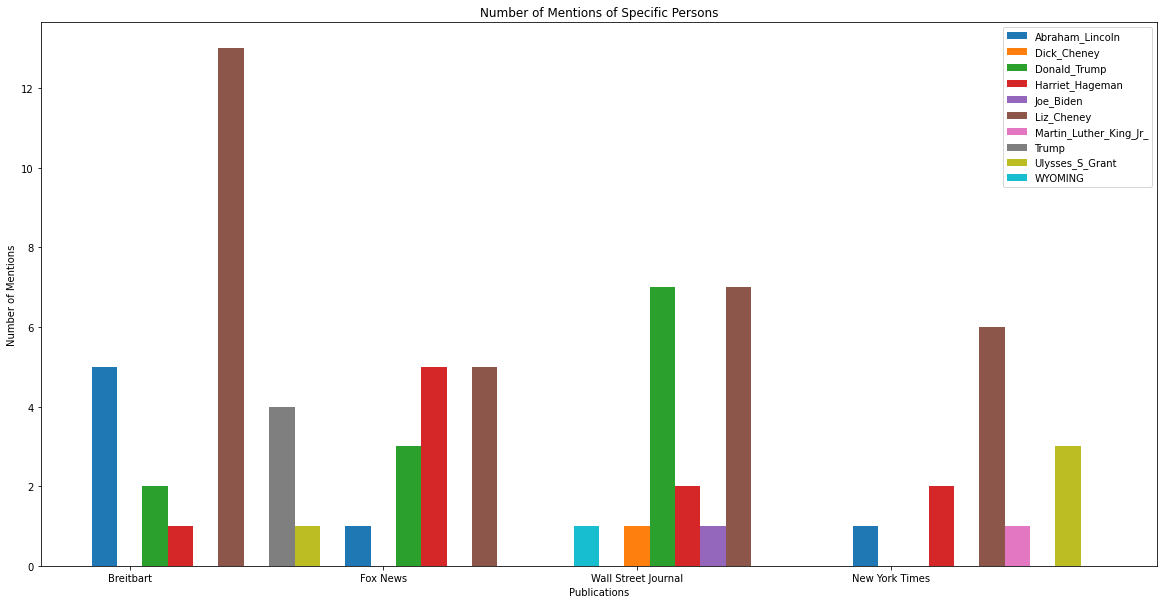

In [17]:
# Display a table of people and counts of their occurrences in the narratives
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy

pubs = list(publisher_dict.keys())
persons = list(person_mentions_dict.keys())
X_axis = np.arange(len(pubs))
start = -0.1
for person, count_array in person_mentions_dict.items():
    plt.bar(X_axis + start, count_array, 0.1, label = person)
    start += 0.1

plt.rcParams['figure.figsize'] = [30, 15]
plt.xticks(X_axis, pubs)
plt.xlabel("Publications")
plt.ylabel("Number of Mentions")
plt.title("Number of Mentions of Specific Persons")
plt.legend()
plt.show()


In [20]:
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections


In [8]:
# Breitbart events from the first 5 paragraphs
query = \
    'prefix : <urn:ontoinsights:dna:> prefix dna: <urn:ontoinsights:dna:> prefix dc: <http://purl.org/dc/terms/> ' \
    'select distinct ?sentenceOffset ?chunkOffset ?chunkText ?eventLabel where { ' \
    '  ?s a :Narrative ; dc:publisher "Breitbart" . ' \
    '  BIND(IRI(CONCAT("urn:ontoinsights:dna:", STRAFTER(str(?s), "Narrative_"))) as ?g) . ' \
    '  {graph ?g {?sentence a :Sentence ; :offset ?sentenceOffset .' \
    '     OPTIONAL {?sentence :has_component ?chunk . ?chunk :offset ?chunkOffset ; :text ?chunkText . ' \
    '        OPTIONAL {?chunk :describes ?event . ?event rdfs:label ?eventLabel}}}}} ' \
    'ORDER BY ?sentenceOffset ?chunkOffset' 

conn = stardog.Connection('short-news-db', **sd_conn_details)

query_results = conn.select(query, content_type='application/sparql-results+json')
if 'results' in query_results and 'bindings' in query_results['results']:
    bindings = query_results['results']['bindings']
else:
    bindings = []

story_arc_dict = dict()
for binding in bindings:
    sent_offset = int(binding['sentenceOffset']['value'])
    chunk_offset = int(binding['chunkOffset']['value']) - 1
    if 'eventLabel' in binding:
        label = binding['eventLabel']['value']
    else:
        label = binding['chunkText']['value']
    if sent_offset in story_arc_dict:
        arc_text = story_arc_dict[sent_offset] + '\n'
    else:
        arc_text = ''
    lf_label = ''
    add_new_line = False
    for i in range(0,len(label)):
        if i in (20, 40, 60):
            add_new_line = True
        if i >= 75:
            break
        if add_new_line and label[i] == ' ':
            add_new_line = False
            lf_label += '\n'
        else:
            lf_label += label[i]
    arc_text += lf_label 
    story_arc_dict[sent_offset] = arc_text

print(story_arc_dict)

StardogException: [404] 0D0DU2: Database 'short-news-db' does not exist.

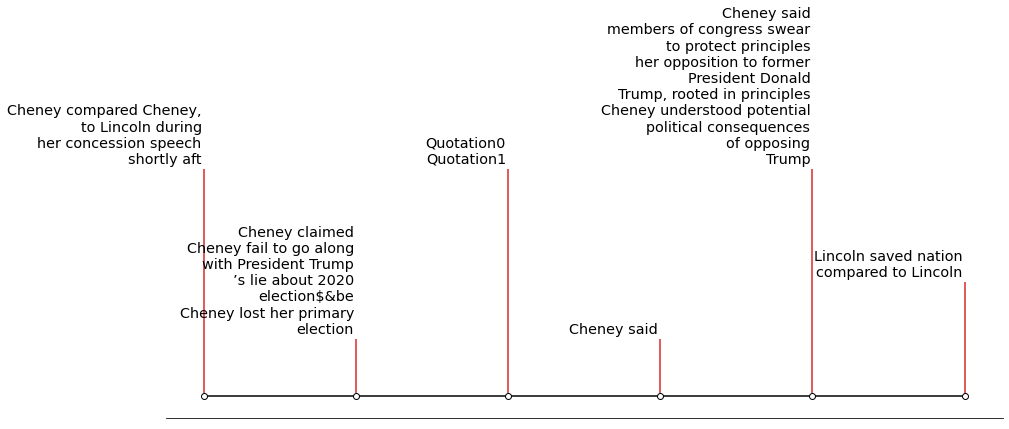

In [19]:
len_arc = len(story_arc_dict)
# For matplotlib timeline, need datetime formatting
title = 'Breitbart Article'
events = []
for key, arc_text in story_arc_dict.items():
    events.append(arc_text)
plot_dates = np.arange(len(events))
# Create a stem plot with some variation in levels as to distinguish close-by events.
# Add markers on the baseline with dates
# For each event, add a text label via annotate, which is offset from the tip of the event line
levels = np.tile([4, 1, 4, 1, 4, 2],
                 int(np.ceil(len(plot_dates) / 6)))[:len(plot_dates)]
# Create figure and plot a stem plot with the dates
fig, ax = plt.subplots()
dpi = fig.get_dpi()
fig.set_size_inches(15, 5)
ax.vlines(plot_dates, 0, levels, color="tab:red")  # The vertical stems
ax.plot(plot_dates, np.zeros_like(plot_dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it
# Annotate lines
for d, l, r in zip(plot_dates, levels, events):
    ax.annotate(r, xy=(d, l),
                xytext=(-2, np.sign(l) * 3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top", fontsize='x-large')
# Format x-axis with yearly intervals
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontsize='medium')
# Remove x- and y-axis and spines
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)
ax.margins(y=0.1)
plt.rcParams['figure.figsize'] = [15, 8]
plt.show()

In [21]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def number_of_pendants(g):
    """
    Equals the number of nodes with degree 1
    """
    pendants = 0
    for u in g:
        if g.degree[u] == 1:
            pendants += 1
    return pendants


def histogram(l):
    degree_sequence = sorted([d for n, d in list(l.items())], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    print(deg, cnt)
    
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Histogram")
    plt.ylabel("Count")
    plt.xlabel("Value")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

LC-Left.ttl
rdflib Graph loaded successfully with 192 triples
networkx Graph loaded successfully with length 135
NETWORK SIZE
The network has 135 nodes and 190 edges

PENDANTS/Nodes with degree 1
The network has 79 pendants

DENSITY
The network density is 0.021006080707573246

DEGREE CENTRALITY
The mean degree centrality is 0.02100608070757329, with stdev 0.020773943496003675
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.11940298507462686
The minimum node is Harriet Hageman, with value 0.007462686567164179
(0.11940298507462686, 0.09701492537313433, 0.07462686567164178, 0.06716417910447761, 0.05970149253731343, 0.04477611940298507, 0.03731343283582089, 0.029850746268656716, 0.022388059701492536, 0.014925373134328358, 0.007462686567164179) (1, 1, 3, 2, 1, 17, 11, 8, 3, 9, 79)


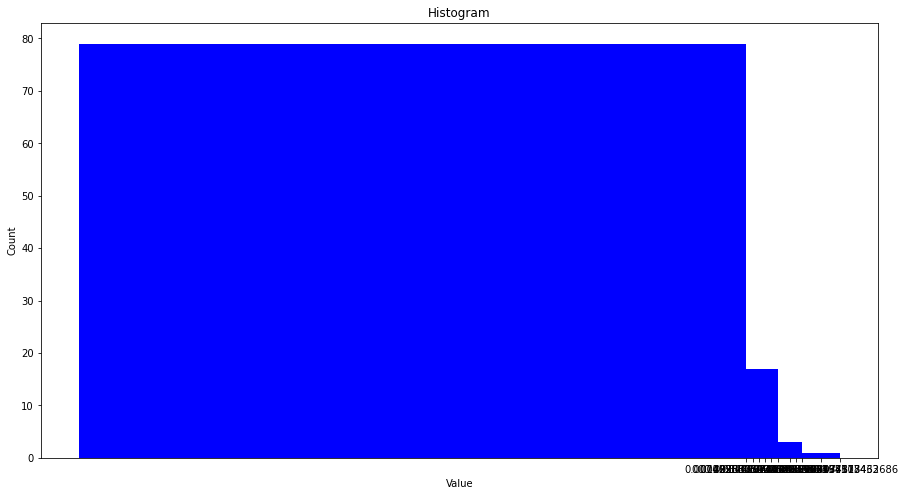


EIGENVECTOR CENTRALITY
The mean network eigenvector centrality is 0.05167387716813297, with stdev 0.06908379113550867
The maximum node is urn:ontoinsights:dna:Chunk, with value 0.4035142802359184
The minimum node is more than 30 percentage point loss to Trump-endorsed Republican Harriet Hageman, with value 0.0014207712261218714
(0.4035142802359184, 0.304052383713264, 0.2509776340631398, 0.22682878585842886, 0.20900027679561806, 0.1989260753133008, 0.1981562294935518, 0.1971077692820251, 0.1936178411924289, 0.18865887074796162, 0.1817546942460326, 0.17421302825023302, 0.1715506140169869, 0.1657548853142782, 0.16099396033270622, 0.14985662413889603, 0.14181983855065186, 0.1373702903709384, 0.13338594315496677, 0.13075303754262876, 0.1240985956755833, 0.11935910246988506, 0.10685693962096877, 0.10580430881884628, 0.09455425217227667, 0.07935883372271721, 0.07286275605720809, 0.07114425701194939, 0.06921783193823865, 0.06677431782233414, 0.06640253286992055, 0.0603577099375772, 0.05227799

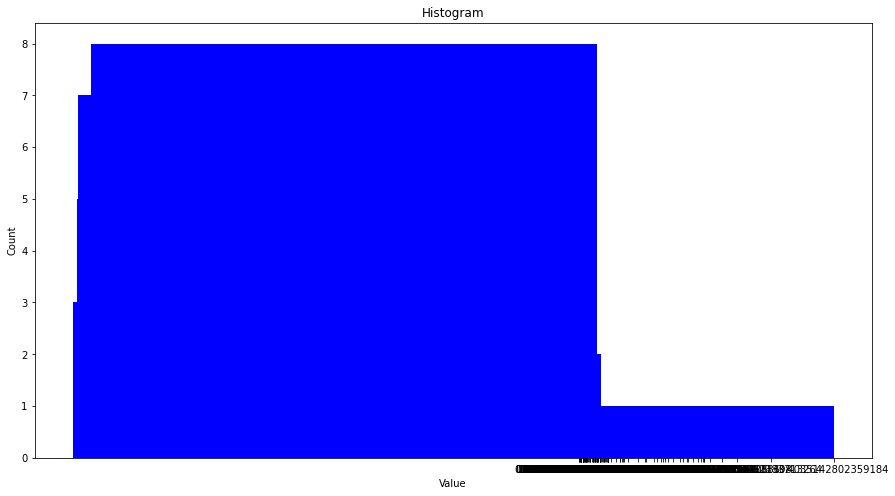


BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.024792495334522036, with stdev 0.047309400284571757
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.2787978131168061
The minimum node is Harriet Hageman, with value 0.0
(0.2787978131168061, 0.2631825406673973, 0.20614715709347614, 0.12969037725699223, 0.11862568879360391, 0.11442029737530864, 0.11309202442562591, 0.10768850535811075, 0.10736326189305029, 0.0910132602905595, 0.09026971125658372, 0.09025729050341551, 0.08383078830817071, 0.08196299901756503, 0.07883879787315758, 0.0771091248952752, 0.07350465716530132, 0.06949263932124138, 0.06882686809504267, 0.06484484107076598, 0.06276790199736978, 0.06127779348236398, 0.06090694549044853, 0.06046786447134331, 0.05943379935830739, 0.05763104418555808, 0.05180548484080384, 0.0510196474036366, 0.04253728114209251, 0.04149383129816902, 0.039263704145546995, 0.03860694863284978, 0.03706513199567252, 0.03632579600293025, 0.03214164356572616, 0.02973852541802267, 

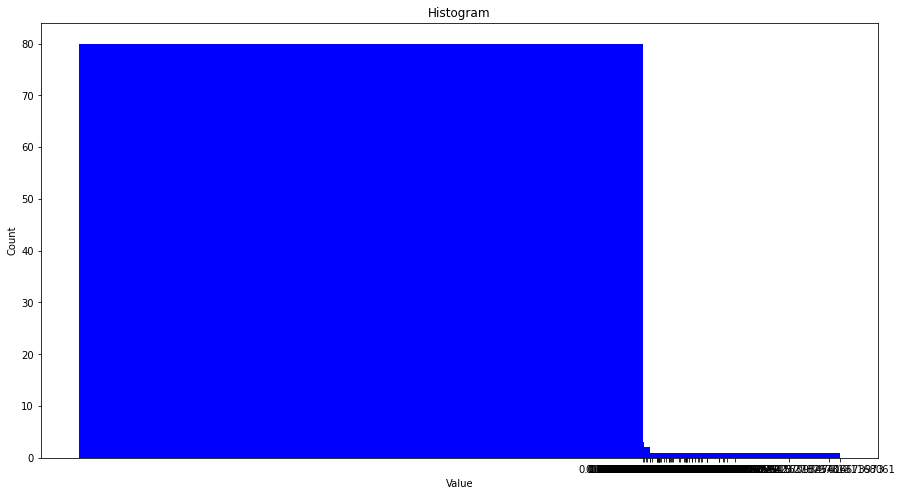


Visualizing the graph:
CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 135 nodes

LC-Center.ttl
rdflib Graph loaded successfully with 335 triples
networkx Graph loaded successfully with length 239
NETWORK SIZE
The network has 239 nodes and 333 edges

PENDANTS/Nodes with degree 1
The network has 147 pendants

DENSITY
The network density is 0.01170844907000457

DEGREE CENTRALITY
The mean degree centrality is 0.011708449070004548, with stdev 0.013634375452516731
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.11764705882352941
The minimum node is 3, with value 0.004201680672268907
(0.11764705882352941, 0.08403361344537814, 0.06302521008403361, 0.04621848739495798, 0.04201680672268907, 0.037815126050420166, 0.03361344537815126, 0.029411764705882353, 0.025210084033613446, 0.021008403361344536, 0.01680672268907563, 0.012605042016806723, 0.008403361344537815, 0.004201680672268907) (1, 1, 1, 2, 3, 4, 3, 9, 18, 12, 11, 15, 12, 147)


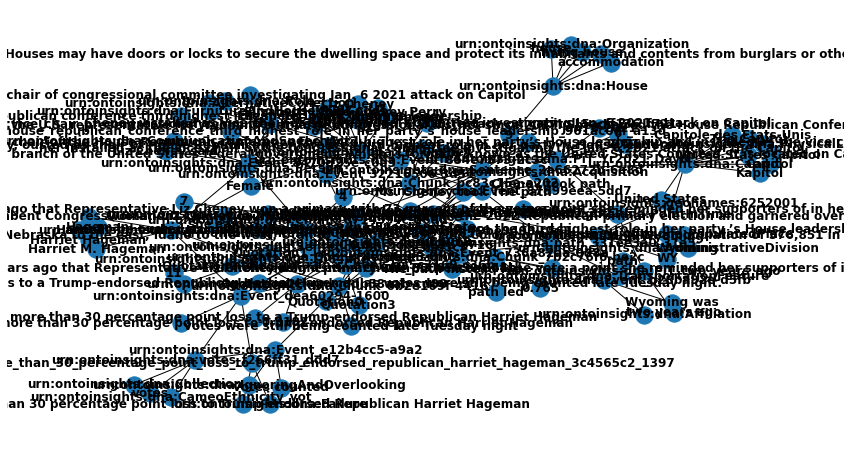

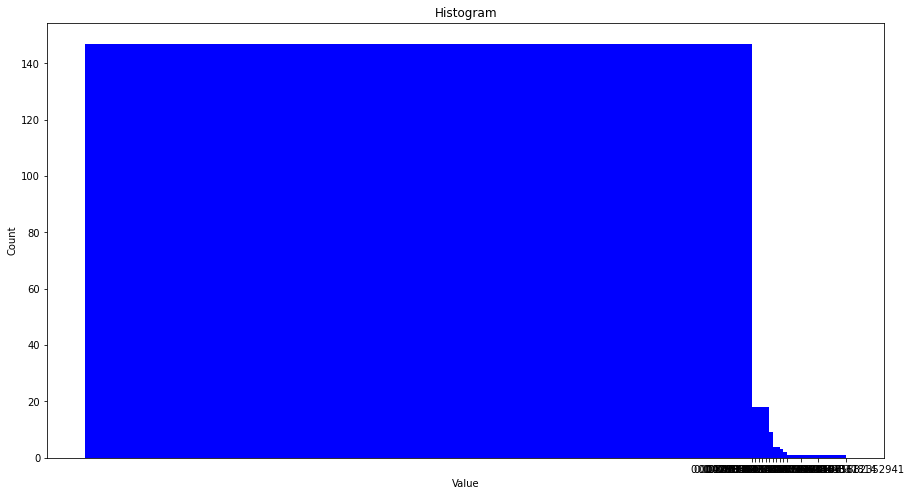


EIGENVECTOR CENTRALITY
The mean network eigenvector centrality is 0.03920794631988471, with stdev 0.05155539282345882
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.3378391289646277
The minimum node is urn:ontoinsights:dna:Decrease, with value 0.00044691541444360263
(0.3378391289646277, 0.2882016503969303, 0.25529679596929516, 0.2520195026620805, 0.2265234570695464, 0.1933417485784205, 0.162639488363617, 0.15774683512735052, 0.15725804002049912, 0.1531520419500824, 0.13700858095597138, 0.13512214863584548, 0.13240064209922903, 0.12779164590716047, 0.1276664665040417, 0.1273526916002205, 0.12557528085856418, 0.12504519167692651, 0.12451635307592712, 0.12183511428208635, 0.12121544046053874, 0.1200661111703004, 0.11541609305716831, 0.11113385458237247, 0.10970569918317774, 0.10840021274855972, 0.10476683525397049, 0.10358891296319907, 0.1009608317157232, 0.09333465728485016, 0.0889141598189252, 0.08494519075924645, 0.07882259239338611, 0.07848778504100228, 0.0745426

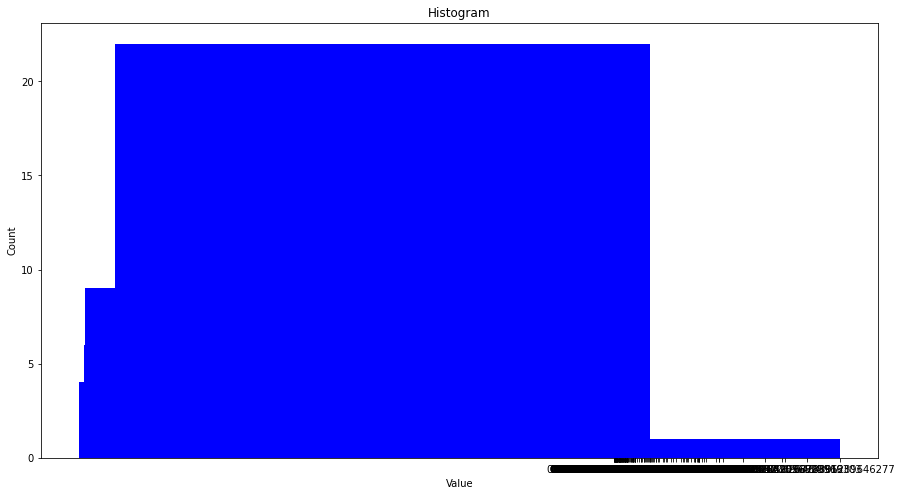


BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.015276424642204743, with stdev 0.03359886372784151
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.22587914957166977
The minimum node is 3, with value 0.0
(0.22587914957166977, 0.21325542212334933, 0.20925170227437553, 0.17547021605273008, 0.1382939871921168, 0.10560572887695312, 0.09678536430215141, 0.09632622281901776, 0.07864233627279595, 0.07683173159511583, 0.07212869842812972, 0.0681901116304575, 0.06584895826213107, 0.06508481990076344, 0.06299422247157056, 0.06127464943617936, 0.060243390207290505, 0.05815980743426769, 0.05703812629217647, 0.05693469486822193, 0.053186863220350766, 0.052152603335467555, 0.051942842403483146, 0.050305545974545555, 0.04998370463319315, 0.04923585745488875, 0.048963135975841995, 0.04853227267841309, 0.04736604299818051, 0.044575360705429536, 0.043579522273821676, 0.042777540611561096, 0.04266163162566636, 0.04261720975338149, 0.036250070718404456, 0.03421224352387475, 

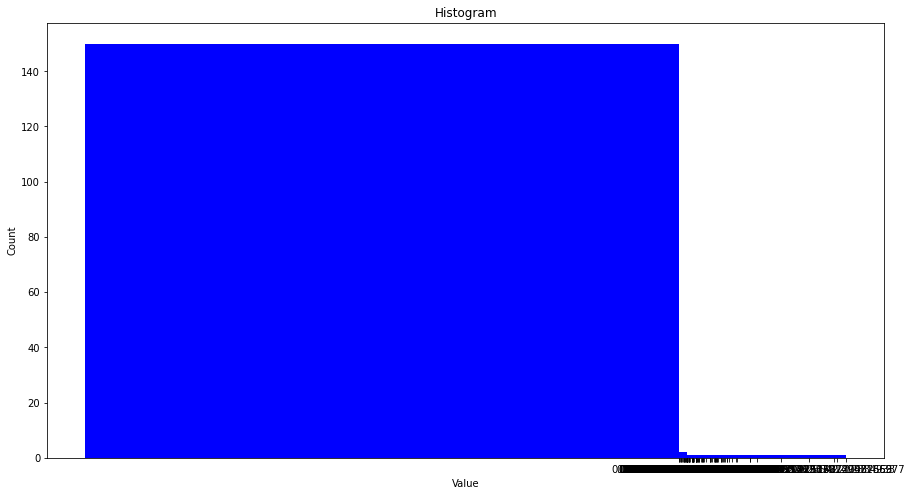


Visualizing the graph:
CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 239 nodes

LC-Right.ttl
rdflib Graph loaded successfully with 253 triples
networkx Graph loaded successfully with length 188
NETWORK SIZE
The network has 188 nodes and 248 edges

PENDANTS/Nodes with degree 1
The network has 123 pendants

DENSITY
The network density is 0.014108544771873933

DEGREE CENTRALITY
The mean degree centrality is 0.014108544771873949, with stdev 0.017538291030573368
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.1443850267379679
The minimum node is Harriet M. Hageman, with value 0.0053475935828877
(0.1443850267379679, 0.1016042780748663, 0.0748663101604278, 0.0641711229946524, 0.053475935828877004, 0.0481283422459893, 0.0427807486631016, 0.0374331550802139, 0.0320855614973262, 0.026737967914438502, 0.0213903743315508, 0.0160427807486631, 0.0106951871657754, 0.0053475935828877) (1, 1, 1, 1, 1, 3, 5, 5, 11, 7, 11, 8, 10, 123)


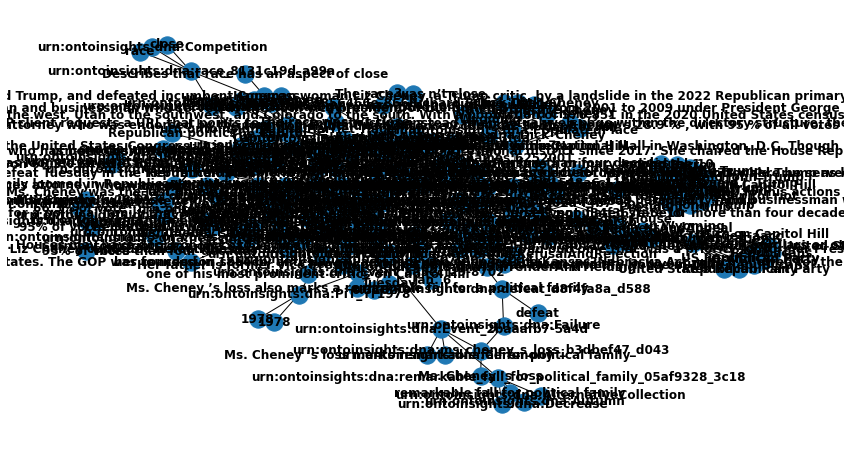

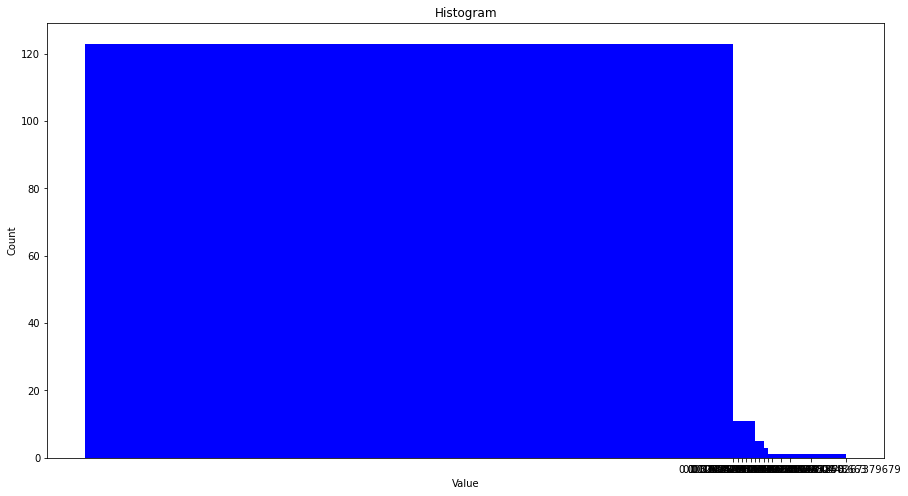


EIGENVECTOR CENTRALITY
The mean network eigenvector centrality is 0.04629066268498398, with stdev 0.056509372421195296
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.3409253265784747
The minimum node is arguing that he should never be elected president again, with value 0.0005403403406548825
(0.3409253265784747, 0.3184186456308802, 0.23044227855329247, 0.22346907995236445, 0.2079312061798715, 0.20209784489595575, 0.1890912647268928, 0.18000025287322588, 0.17629850036327027, 0.17318707833526903, 0.16899879736099807, 0.16070103172614028, 0.15421714417188417, 0.1540060823959657, 0.12915513368939605, 0.12741593911984245, 0.1238437839828199, 0.11795047397175153, 0.11585684352399973, 0.11329690232839756, 0.10589934858404218, 0.1017460345388617, 0.10166989498894023, 0.10118157010216103, 0.09498461487175716, 0.09234910691850098, 0.09017258957983108, 0.08574447710096378, 0.0846282730892775, 0.08422069250714788, 0.08324639719827627, 0.0827029543400439, 0.08181293488102367, 0.

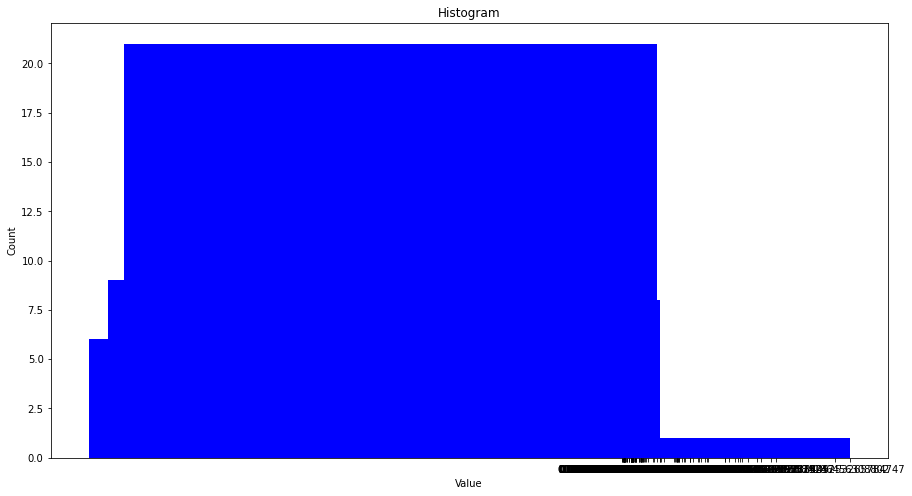


BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.019330431367655308, with stdev 0.04541848738761785
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.3062809218547908
The minimum node is Harriet M. Hageman, with value 0.0
(0.3062809218547908, 0.268037110808699, 0.21142218933693435, 0.17032322179578127, 0.16663811567116352, 0.14501861671291408, 0.14126790677072537, 0.13237560842518975, 0.10908428455775393, 0.10890913603485182, 0.10084996306293811, 0.09747589181488772, 0.0972751499711966, 0.08737252832774235, 0.0850734623114592, 0.0825636559959336, 0.08000607947143358, 0.06844060064990078, 0.0680908747165666, 0.0653946734831991, 0.06073989928478086, 0.05700963862208523, 0.05311925725932971, 0.05290092576620091, 0.04793917963004907, 0.04743320170556191, 0.04253907210608953, 0.037301493470541305, 0.033609043386472685, 0.031913058478523375, 0.031886292249259575, 0.0306110193057162, 0.02905003964376781, 0.02812683977581277, 0.025621000994004533, 0.025608797505222

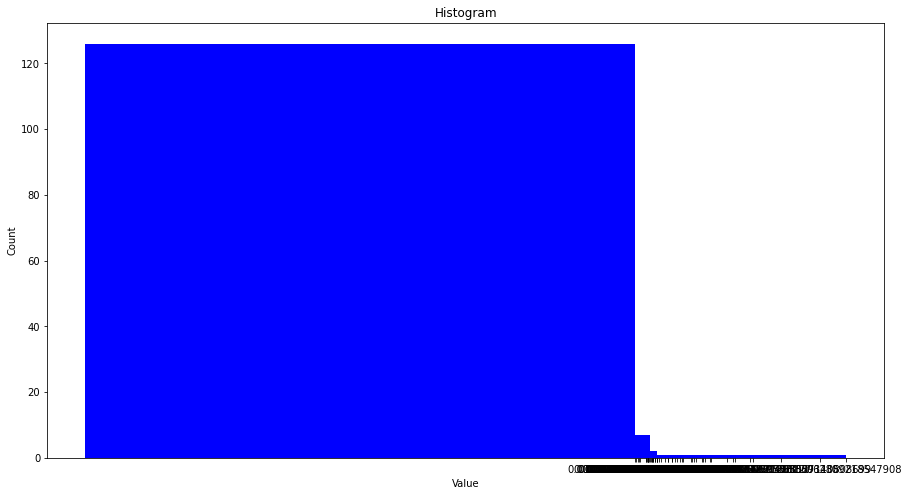


Visualizing the graph:
CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 188 nodes

LC-Right.ttl
rdflib Graph loaded successfully with 253 triples
networkx Graph loaded successfully with length 188
NETWORK SIZE
The network has 188 nodes and 248 edges

PENDANTS/Nodes with degree 1
The network has 123 pendants

DENSITY
The network density is 0.014108544771873933

DEGREE CENTRALITY
The mean degree centrality is 0.014108544771873953, with stdev 0.017538291030573368
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.1443850267379679
The minimum node is pure delight, with value 0.0053475935828877
(0.1443850267379679, 0.1016042780748663, 0.0748663101604278, 0.0641711229946524, 0.053475935828877004, 0.0481283422459893, 0.0427807486631016, 0.0374331550802139, 0.0320855614973262, 0.026737967914438502, 0.0213903743315508, 0.0160427807486631, 0.0106951871657754, 0.0053475935828877) (1, 1, 1, 1, 1, 3, 5, 5, 11, 7, 11, 8, 10, 123)


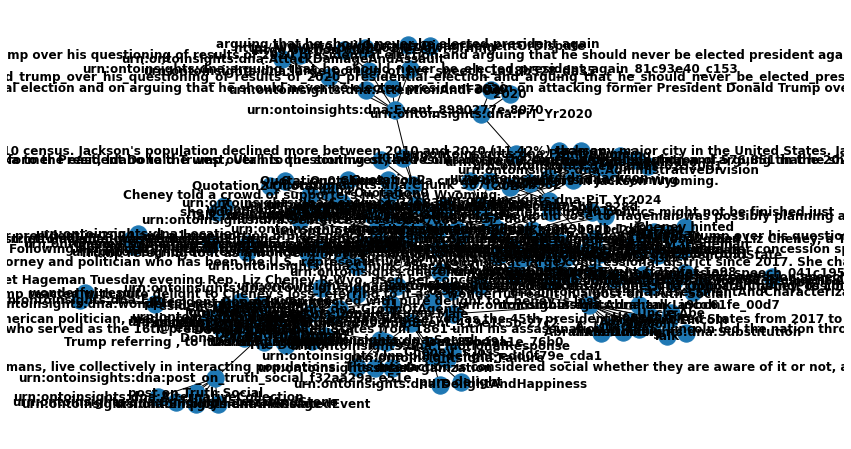

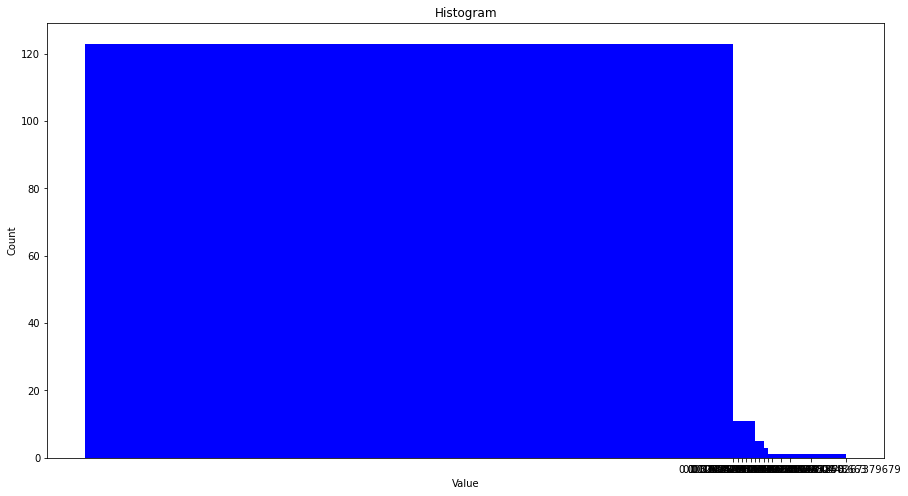


EIGENVECTOR CENTRALITY
The mean network eigenvector centrality is 0.04629066268498401, with stdev 0.056509372421195296
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.34092532657847474
The minimum node is large portion of her speech, with value 0.0005403403406548825
(0.34092532657847474, 0.3184186456308802, 0.23044227855329247, 0.2234690799523645, 0.20793120617987151, 0.20209784489595575, 0.18909126472689283, 0.18000025287322585, 0.1762985003632703, 0.17318707833526906, 0.16899879736099804, 0.1607010317261403, 0.15421714417188417, 0.15400608239596567, 0.12915513368939605, 0.12741593911984245, 0.12384378398281991, 0.11795047397175154, 0.11585684352399973, 0.1132969023283976, 0.10589934858404217, 0.10174603453886172, 0.10166989498894026, 0.101181570102161, 0.09498461487175716, 0.09234910691850098, 0.09017258957983108, 0.08574447710096379, 0.08462827308927753, 0.08422069250714788, 0.08324639719827628, 0.08270295434004393, 0.08181293488102367, 0.08165320547794609, 0.0802

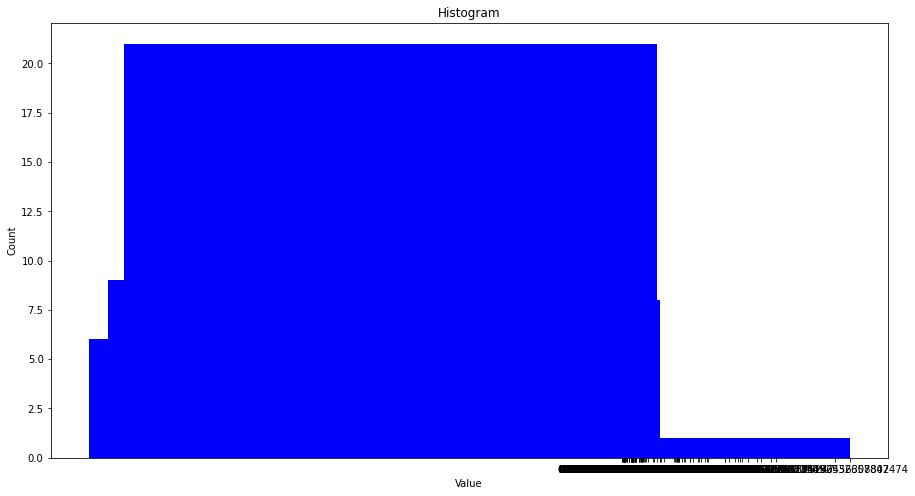


BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.019330431367655315, with stdev 0.04541848738761786
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.30628092185479106
The minimum node is pure delight, with value 0.0
(0.30628092185479106, 0.2680371108086992, 0.21142218933693432, 0.17032322179578122, 0.16663811567116357, 0.14501861671291416, 0.14126790677072543, 0.13237560842518983, 0.10908428455775399, 0.1089091360348518, 0.10084996306293814, 0.0974758918148877, 0.0972751499711966, 0.08737252832774228, 0.08507346231145921, 0.08256365599593357, 0.08000607947143358, 0.0684406006499007, 0.06809087471656657, 0.06539467348319909, 0.0607398992847809, 0.057009638622085246, 0.0531192572593297, 0.05290092576620091, 0.04793917963004906, 0.047433201705561916, 0.042539072106089516, 0.03730149347054127, 0.03360904338647269, 0.031913058478523375, 0.03188629224925957, 0.0306110193057162, 0.029050039643767796, 0.028126839775812793, 0.025621000994004522, 0.02560879750522211

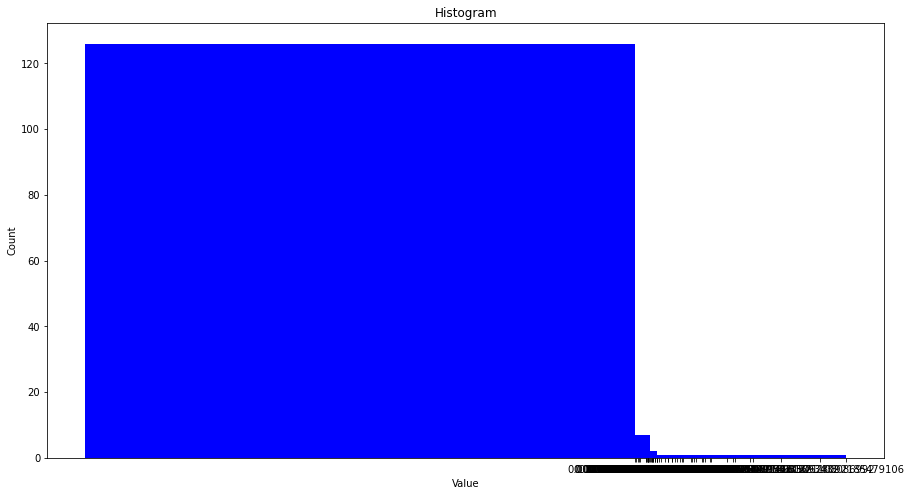


Visualizing the graph:
CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 188 nodes



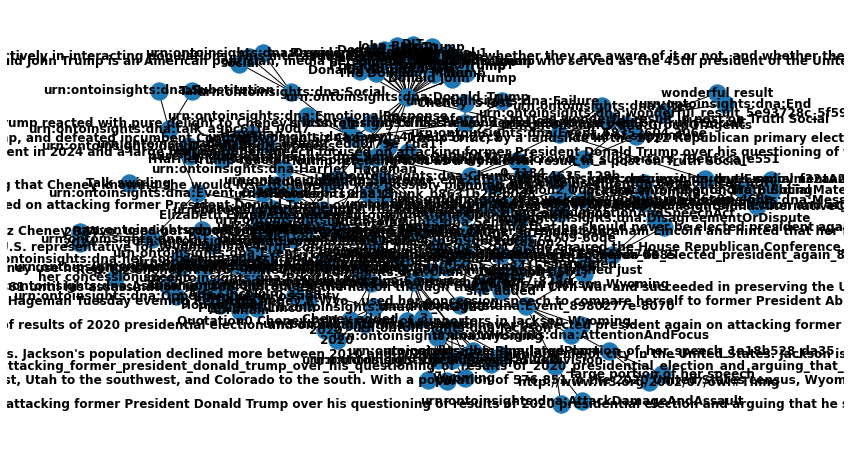

In [23]:
for i in range(4):
    # TTL files were saved from an earlier test run of DNA but can also be retrieved using the
    # GET /dna/v1/repositories/narratives/graphs API
    if i == 0:
        title = 'LC-Left.ttl'
    elif i == 1:
        title = 'LC-Center.ttl'
    elif i == 2:
        title = 'LC-Right.ttl'
    print(title)
    rg = RDFGraph()
    rg.parse(title, format='turtle')
    print("rdflib Graph loaded successfully with {} triples".format(len(rg)))
    G = rdflib_to_networkx_graph(rg)
    print("networkx Graph loaded successfully with length {}".format(len(G)))
    
    # Network size
    print("NETWORK SIZE")
    print("============")
    print("The network has {} nodes and {} edges".format(G.number_of_nodes(), G.number_of_edges()))
    print()

    # Network size
    print("PENDANTS/Nodes with degree 1")
    print("============")
    print("The network has {} pendants".format(number_of_pendants(G)))
    print()

    # Density
    print("DENSITY")
    print("============")
    print("The network density is {}".format(nx.density(G)))
    print()

    # Degree centrality -- mean and stdev
    dc = nx.degree_centrality(G)
    degrees = []
    for k,v in dc.items():
        degrees.append(v)

    print("DEGREE CENTRALITY")
    print("=================")
    print("The mean degree centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(dc, key=dc.get), max(dc.values())))
    print("The minimum node is {}, with value {}".format(min(dc, key=dc.get), min(dc.values())))
    histogram(dc)
    print()
    
    # Eigenvector centrality -- mean and stdev
    ec = nx.eigenvector_centrality(G)
    degrees = []
    for k,v in ec.items():
        degrees.append(v)

    print("EIGENVECTOR CENTRALITY")
    print("======================")
    print("The mean network eigenvector centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(ec, key=ec.get), max(ec.values())))
    print("The minimum node is {}, with value {}".format(min(ec, key=ec.get), min(ec.values())))
    histogram(ec)
    print()

    # Betweenness centrality -- mean and stdev
    bc = nx.betweenness_centrality(G)
    degrees = []
    for k,v in bc.items():
        degrees.append(v)
    print("BETWEENNESS CENTRALITY")
    print("======================")
    print("The mean betwenness centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(bc, key=bc.get), max(bc.values())))
    print("The minimum node is {}, with value {}".format(min(bc, key=bc.get), min(bc.values())))
    histogram(bc)
    print()

    # Plot
    print("Visualizing the graph:")
    plt.plot()
    nx.draw(G, with_labels=True, font_weight='bold')

    # Connected components
    cc = list(nx.connected_components(G))
    print("CONNECTED COMPONENTS")
    print("====================")
    print("The graph has {} connected components".format(len(cc)))
    for i,c in enumerate(cc):
        print("Connected component {} has {} nodes".format(i,len(c)))
    print()